In [1]:
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt

alt.renderers.enable('mimetype')

import warnings
warnings.filterwarnings("ignore")

In [2]:
country_filter: str = 'Kenya'

In [3]:
death_cause_source = 'datasets/causes-of-death-in-children.csv'
death_cause_df = pd.read_csv(death_cause_source)

#death_cause_df.sample(2)
death_cause_df.drop(columns='Code', inplace=True)
death_cause_df.columns = (death_cause_df.columns.str.replace("Sex: Both - Age: ","").str.replace("/","").str.replace(" - ","_")
                          .str.replace("Number","").str.replace(")","").str.replace("(","").str.replace(" ","_").str.lower())

kenya_under5_df = death_cause_df.query('entity == @country_filter')
kenya_under5_df.drop(columns="entity", inplace=True)

#%mkdir prepped_data

kenya_under5_df.to_csv('prepped_data/kenya_deaths_under_five.csv', index=False)

In [4]:
age_group = (pd
             .read_csv('datasets/tuberculosis-death-rates-by-age.csv')
             .query('Entity == @country_filter')
             .drop(columns = ['Entity','Code']))

age_group.columns = age_group.columns.str.replace("(","").str.replace(")","").str.replace(" Sex: Both - ","").str.replace("Age:","").str.replace(" - ","_").str.replace(" ","_").str.lower()

age_group.to_csv('prepped_data/kenya_tb_agegroup_death_rates.csv', index=False)

#### line chart test tooltip and conditional color

In [5]:
alt.Chart(age_group).mark_line(point=True).encode(
 x='year:O',
 y='deaths_tuberculosis_under_5_rate:Q',
 color= alt.condition(alt.datum.year >= 2004 , alt.value("red"), alt.value("grey")),
 tooltip=['year', 'deaths_tuberculosis_under_5_rate']
).interactive()

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


### Under five tb deaths in east africa line chart

In [6]:
linechart = alt.Chart(death_cause_df[death_cause_df.entity.str.contains('Kenya|Uganda|Tanzania|Sudan|South Sudan|Rwanda|Djibouti')]).mark_line(point=True).encode(
    alt.X('year:O'),
    alt.Y('deaths_tuberculosis_under_5_:Q', axis=alt.Axis(tickCount=6)), 
    alt.OpacityValue(0.8),
    alt.Color("entity", scale=alt.Scale(scheme="greys"), legend=None),
    #tooltip=['entity','deaths_tuberculosis_under_5_:Q']
)

kenyachart = alt.Chart(death_cause_df[death_cause_df.entity.str.contains('Kenya')], 
                  title="Under 5 deaths from Tuberculosis among Kenya and her neighbors").mark_line(point=True, color="darkorange").encode(
    alt.X('year:O'),
    alt.Y('deaths_tuberculosis_under_5_:Q', axis=alt.Axis(tickCount=6)),
    color=alt.condition(alt.datum.entity == "Kenya" , alt.value("darkorange"), alt.value("grey"))
)

country_list =['Kenya','Uganda','Tanzania','Sudan','South Sudan','Rwanda','Djibouti']

label = linechart.mark_text(dx=3, align='left').encode(alt.X('max(year):O', title=""),
                                                   alt.Y('deaths_tuberculosis_under_5_:Q',  aggregate={'argmax':'year'}, title=""),
                                                   alt.Text('entity:O'),
                                                   color=alt.condition(alt.datum.entity == "Kenya" , alt.value("darkorange"), alt.value("grey")))

(linechart + kenyachart + label).properties(width=1200, height=400,
                                            title={"text":"Number of deaths from tuberculosis; children under 5 years",
                                                   "fontSize":14,
                                                   "color":"darkorange",
                                                   "anchor":"start",
                                                   "offset":10,
                                                   "subtitle":"Annual reported TB deaths of under 5 in Kenya and other East African countries, from 1990 to 2019.",
                                                   "subtitleFontSize":14,
                                                   "subtitleColor":"gray"}
                                           ).configure_view(stroke=None)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


### Under five causes of death slope chart

In [7]:
slope = alt.Chart(kenya_under5_df[(kenya_under5_df.year == kenya_under5_df.year.min()) | (kenya_under5_df.year == kenya_under5_df.year.max())]).transform_fold(
['deaths_malaria_under_5_','deaths_hivaids_under_5_',
 'deaths_meningitis_under_5_','deaths_nutritional_deficiencies_under_5_',
 'deaths_lower_respiratory_infections_under_5_','deaths_measles_under_5_',
 'deaths_neonatal_sepsis_and_other_neonatal_infections_under_5_',
 'deaths_neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma_under_5_',
 'deaths_tuberculosis_under_5_','deaths_diarrheal_diseases_under_5_'],
).mark_line().encode(
    alt.X('year:O', title=""),
    alt.Y('value:Q', title="number of deaths", axis=alt.Axis(tickCount=4)),
    alt.Color('key:N', scale=alt.Scale(scheme="greys"), legend=None),
    alt.OpacityValue(0.8)).properties(width={"step":300},height=500)

labeltextmax = slope.mark_text(dx=40, dy=0,
                            align='left', baseline='middle',
                            fontWeight='bold').encode(alt.X('max(year):O', title=""),
                                                   alt.Y('value:Q',  aggregate={'argmax':'year'}, title=""),
                                                   alt.Text('key:N'))
labelvaluemax = slope.mark_text(dx=20, dy=0, 
                                align='left', baseline='middle').encode(alt.X('max(year):O', title=""),
                                                                        alt.Y('value:Q', aggregate={'argmax':'year'}),
                                                                        alt.Text("value:Q"))

labeltextmin = slope.mark_text(dx=-40, dy=0,
                            align='right', baseline='middle',
                            fontWeight='bold').encode(alt.X('min(year):O', title=""),
                                                   alt.Y('value:Q',  aggregate={'argmin':'year'}, title=""),
                                                   alt.Text('key:N'))

labelvaluemin = slope.mark_text(dx=-20, dy=0, 
                                align='right', baseline='middle').encode(alt.X('min(year):O', title=""),
                                                                        alt.Y('value:Q', aggregate={'argmin':'year'}),
                                                                        alt.Text("value:Q"))

(slope + labeltextmin + labeltextmax).properties().configure_view(stroke=None)


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


### Age group tb deaths normalized stacked bar chart

In [8]:
selection = alt.selection_single(fields=['key'], bind='legend')

alt.Chart(age_group).transform_fold([
    'deaths_tuberculosis_under_5_rate',
    'deaths_tuberculosis_70+_years_rate',
    'deaths_tuberculosis_5-14_years_rate',
    'deaths_tuberculosis_15-49_years_rate',
    'deaths_tuberculosis_50-69_years_rate']).mark_bar().encode(
alt.X('year:O', title=""),
alt.Y('value:Q', stack='normalize', axis=alt.Axis(format="%", tickCount=5), title=""),
alt.Color('key:N', scale=alt.Scale(scheme='viridis'),
                                   #domain=['Below 5 Years','70+ Years','5-14 Years','15-49 Years','50-69 Years']),
                                   legend=alt.Legend(orient="top", title="")),
opacity=alt.condition(selection, alt.value(1), alt.value(0.3))).add_selection(selection).properties(
    height=400,
    width=1200,
    title={"text":"TB Deaths Rates In Kenya in 5 key age groups",
           "anchor":"start",
           "offset":10,
           "subtitle":"Data visualized in contribution of each age group to the overall reported deaths. 5-14 years age group making up the lowest numbers in mortality rates resulting from TB while 70+ years makes up for the highest numbers",
           "subtitleFontSize":12})

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [9]:
(age_group['deaths_tuberculosis_under_5_rate']/((age_group['deaths_tuberculosis_under_5_rate']+age_group['deaths_tuberculosis_70+_years_rate']+age_group['deaths_tuberculosis_5-14_years_rate']+age_group['deaths_tuberculosis_15-49_years_rate']+age_group['deaths_tuberculosis_50-69_years_rate'])))*100

3000    2.469123
3001    2.320399
3002    2.179076
3003    2.047397
3004    1.932027
3005    1.828453
3006    1.732461
3007    1.628181
3008    1.517439
3009    1.432228
3010    1.403489
3011    1.303099
3012    1.232125
3013    1.209976
3014    1.164326
3015    1.155082
3016    1.141605
3017    1.140003
3018    1.106358
3019    1.114660
3020    1.186414
3021    1.227477
3022    1.186455
3023    1.171977
3024    1.128778
3025    1.049414
3026    0.978538
3027    0.971541
3028    0.922500
3029    0.884860
dtype: float64

In [10]:
#for year in age_group.year:print(age_group.deaths_tuberculosis_under_5_rate)

### Overall tb deaths all ages in Kenya and neighbors

In [11]:
(pd.read_csv('datasets/number-of-deaths-from-tuberculosis-by-world-region.csv').query('Entity == @country_filter').drop(columns =['Code']))

,Entity,Year,Deaths - Tuberculosis - Sex: Both - Age: All Ages (Number)
3000,Kenya,1990,9991
3001,Kenya,1991,10170
3002,Kenya,1992,10522
3003,Kenya,1993,10918
3004,Kenya,1994,11256
3005,Kenya,1995,11542
3006,Kenya,1996,11842
3007,Kenya,1997,12354
3008,Kenya,1998,13007
3009,Kenya,1999,13481


In [12]:
deaths_tb_total = (pd.read_csv('datasets/number-of-deaths-from-tuberculosis-by-world-region.csv').drop(columns =['Code']))
deaths_tb_total.rename(columns={"Deaths - Tuberculosis - Sex: Both - Age: All Ages (Number)":"TB Deaths"}, inplace=True)
ea_tb_deaths = deaths_tb_total[deaths_tb_total.Entity.str.contains('Kenya|Uganda|Tanzania|Sudan|South Sudan|Rwanda|Djibouti')]

In [13]:
ea_deaths = alt.Chart(ea_tb_deaths[(ea_tb_deaths.Year == ea_tb_deaths.Year.min()) | (ea_tb_deaths.Year == ea_tb_deaths.Year.max())]).mark_line().encode(
    alt.X('Year:O', title=""),
    alt.Y('TB Deaths', title="number of deaths", axis=alt.Axis(tickCount=4)),
    alt.Color('Entity:N', scale=alt.Scale(scheme="greys"), legend=None),
    alt.OpacityValue(0.8)).properties(width={"step":300},height=500)

labelna = ea_deaths.mark_text(dx=10, dy=0, align='left', baseline='middle', fontWeight='bold').encode(text="Entity:N")
#label = slope.mark_text(dx=10, dy=0, align='left', baseline='middle').encode(text="value:Q")

(ea_deaths + labelna).properties().configure_view(stroke=None)


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


### TB Incidences in East africa

In [14]:
tb_incidence = (pd.read_csv('datasets/incidence-of-tuberculosis-sdgs.csv').drop(columns='Code'))

incidences = alt.Chart(tb_incidence[tb_incidence.Entity.str.contains('Kenya|Uganda|Tanzania|Sudan|South Sudan|Rwanda|Djibouti')]).transform_filter(alt.datum.Entity == 'Kenya').mark_bar(color="grey").encode(
    alt.X("Year:O", title=""), alt.Y("Incidence of tuberculosis (per 100,000 people):Q"),).properties(title="TB incidences in Kenya")

text = incidences.mark_text(align="center", baseline="middle", dy=10, dx=0, fontSize=10).encode(text="Incidence of tuberculosis (per 100,000 people):Q")

(incidences + text).properties(width=800)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


##### incidences of tb in east africa area chart

In [15]:
incidence = alt.Chart(tb_incidence[tb_incidence.Entity.str.contains('Kenya|Uganda|Tanzania|Sudan|South Sudan|Rwanda|Djibouti')]).mark_area(
    line={"color":"darkgrey"},
    color=alt.Gradient(gradient="linear",
                       stops=[alt.GradientStop(color="white", offset=0),
                              alt.GradientStop(color="darkgrey", offset=1),],x1=1,x2=1,y1=1,y2=0
                      )).encode(alt.X('Year:O', title=""),
                                alt.Y('Incidence of tuberculosis (per 100,000 people):Q', axis=alt.Axis(tickCount=12)),
                                alt.OpacityValue(0.8),
                                alt.Color("Entity", scale=alt.Scale(scheme="viridis"),
                                         legend=alt.Legend(orient="top", title=""))
                               ).properties(width=1000, height=400,
                                            title={"text":"TB Incidences in Kenya and her neighbors",
                                                   "anchor":"start",
                                                   "offset":10,
                                                   "subtitle":"Reported incidences of Tuberculosis per 100,000 people for the seven countries; showing change in incidences reported by each of the selected countries over the period of 2000 to 2021."})

country_list =['Kenya','Uganda','Tanzania','Sudan','South Sudan','Rwanda','Djibouti']

incidence_label = incidence.mark_text(dx=3, align='left').encode(alt.X('max(Year):O', title=""),
                                                   alt.Y('Incidence of tuberculosis (per 100,000 people):Q',
                                                         aggregate={'argmax':'Year'},
                                                         title=""),
                                                   alt.Text('Entity:O'),
                                                   alt.Color('Entity:O',
                                                             scale=alt.Scale(domain=country_list,
                                                                             type='ordinal')))

incidence

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


### TB indicators in Kenya

In [16]:
kenyatb_indicators = pd.read_csv('datasets/tuberculosis_indicators_ken.csv')
#pd.read_csv('datasets/tuberculosis_indicators_ken.csv').Indicator.unique()

In [17]:
#alt.Chart(kenyatb_indicators).transform_flatten()

columns to plot

['Incidence of tuberculosis (per 100 000 population per year)','Incidence of tuberculosis (per 100 000 population) (HIV-positive cases)']

['Number of incident tuberculosis cases','Number of incident tuberculosis cases,  (HIV-positive cases)']

['Tuberculosis effective treatment coverage (%)',
'Treatment success rate: new TB cases',
'Treatment success rate: previously treated TB cases',
'Treatment success rate: HIV-positive TB cases',
'Treatment success rate for patients treated for MDR-TB (%)',
'Treatment success rate for new pulmonary smear-negative and extrapulmonary tuberculosis cases',
'Treatment success rate: XDR-TB cases',
'Tuberculosis treatment coverage',]

['Tuberculosis - new and relapse cases',
'New or unknown treatment history cases: Pulmonary, bacteriologically confirmed',
'New cases: Pulmonary, smear-positive',
'New or unknown treatment history cases: Pulmonary, clinically diagnosed',
'New cases: extrapulmonary',
'Relapse cases: Pulmonary, bacteriologically confirmed',
'Relapse cases: Pulmonary, clinically diagnosed',
'Relapse cases: extrapulmonary']

['Confirmed cases of MDR-TB',
'Confirmed cases of MDR-TB started treatment for MDR-TB (%)',
'Confirmed cases of RR-/MDR-TB',
'Cases started on MDR-TB treatment',      
'Estimated MDR-TB cases among notified pulmonary TB cases'] 

['Laboratories providing drug susceptibility testing (DST) (per 5 million population)',
'Laboratories providing tuberculosis diagnostic services using culture (per 5 million population)',
'Laboratories providing tuberculosis diagnostic services using sputum smear microscopy (per 100 000 population)']

In [18]:
alt.Chart(kenyatb_indicators).mark_line().encode(
    x='Year:O', 
    y='Value:Q').transform_filter(alt.datum.Indicator == 'New or unknown treatment history cases: Pulmonary, bacteriologically confirmed') + alt.Chart(kenyatb_indicators).mark_line().encode(
x='Year:O', y='Value:Q').transform_filter(alt.datum.Indicator == 'Relapse cases: Pulmonary, bacteriologically confirmed') 

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [19]:
#alt.Chart(kenyatb_indicators).transform_flatten(['New or unknown treatment history cases: Pulmonary, bacteriologically confirmed','New cases: Pulmonary, smear-positive','New cases: pulmonary smear-negative','New cases: pulmonary smear unknown/not done','New cases: other','New or unknown treatment history cases: Pulmonary, clinically diagnosed','New cases: extrapulmonary','Relapse cases: Pulmonary, bacteriologically confirmed','Relapse cases: Pulmonary, clinically diagnosed',    'Relapse cases: extrapulmonary']).mark_line().encode(x='Year:O', y='Value:Q', color='Indicator:N')

In [20]:
import seaborn as sns

In [21]:
df = kenyatb_indicators[kenyatb_indicators.Indicator.str.contains('Confirmed cases of MDR-TB')]

In [22]:
df

,Indicator,Year,Value
126,Confirmed cases of MDR-TB,2005,44.0
127,Confirmed cases of MDR-TB,2006,89.0
128,Confirmed cases of MDR-TB,2007,82.0
129,Confirmed cases of MDR-TB,2008,102.0
130,Confirmed cases of MDR-TB,2009,150.0
131,Confirmed cases of MDR-TB,2010,112.0
132,Confirmed cases of MDR-TB,2011,166.0
133,Confirmed cases of MDR-TB,2012,225.0
134,Confirmed cases of MDR-TB started treatment fo...,2008,27.0
135,Confirmed cases of MDR-TB started treatment fo...,2009,93.0


<Axes: xlabel='Year', ylabel='Indicator'>

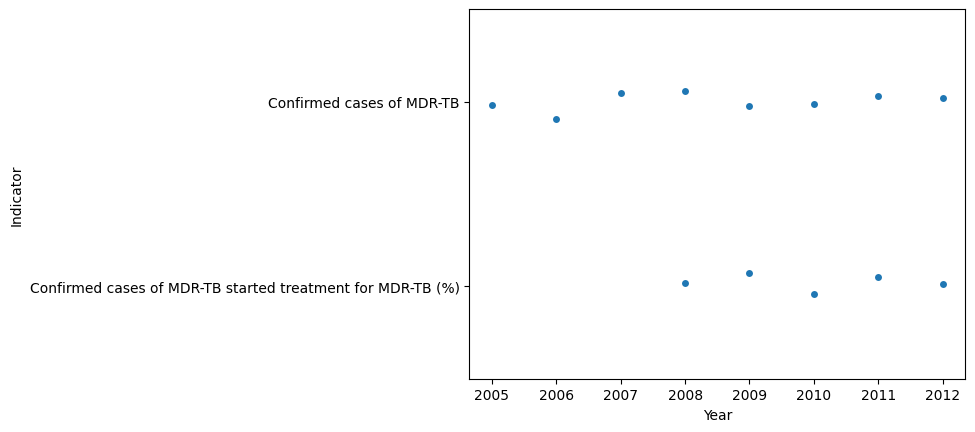

In [23]:
sns.stripplot(data=df, x=df['Year'], y='Indicator')

In [24]:
kenyatb_indicators.Indicator.unique()

array(['Smear-positive tuberculosis case-detection rate (%)',
       'Tuberculosis - new and relapse cases (TB_c_newinc)',
       'New cases: pulmonary smear-negative',
       'New cases: pulmonary smear unknown/not done', 'New cases: other',
       'Retreatment cases: treatment after failure (pulmonary smear and/or culture positive)',
       'Retreatment cases: treatment after default (pulmonary smear and/or culture positive)',
       'Retreatment cases: other',
       'Smear-positive tuberculosis treatment-success rate (%)',
       'Treatment success rate for new pulmonary smear-negative and extrapulmonary tuberculosis cases',
       'Confirmed cases of MDR-TB',
       'Confirmed cases of MDR-TB started treatment for MDR-TB (%)',
       'Estimated MDR-TB cases among notified pulmonary TB cases',
       'Number of prevalent tuberculosis cases',
       'HIV-positive TB patients on CPT (co-trimoxazole preventive therapy) (%)',
       'Second-line drug susceptibility testing (DST) availa

In [25]:
kenyatb_indicators[kenyatb_indicators.Year == 2019]


,Indicator,Year,Value
268,Treatment success rate: new TB cases,2019,86.0
294,Treatment success rate: previously treated TB ...,2019,73.0
308,Treatment success rate: HIV-positive TB cases,2019,80.0
323,Treatment success rate for patients treated fo...,2019,73.0
331,Treatment success rate: XDR-TB cases,2019,56.0
346,Confirmed cases of RR-/MDR-TB,2019,507.0
360,Cases started on MDR-TB treatment,2019,686.0
377,Previously treated cases tested for RR-/MDR-TB...,2019,86.0
393,New cases tested for RR-/MDR-TB (%),2019,76.0
411,TB patients with known HIV status (%),2019,98.0


In [26]:
(pd
 .read_csv('kenyatb_additional_data/TB_laboratories_2024-02-22.csv')
 .query('country == @country_filter'))

,country,iso2,iso3,iso_numeric,g_whoregion,year,lab_sm,lab_sm_eqa,lab_sm_eqa_pass,lab_sm_led,...,dst_moxlev,dst_moxlev_eqa_pass,dst_bdq,dst_bdq_eqa_pass,dst_lzd,dst_lzd_eqa_pass,iso15189_accredited,qms_pending,lmis,m_wrd_etrans
1413,Kenya,KE,KEN,404,AFR,2009,1183.0,614.0,405.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1414,Kenya,KE,KEN,404,AFR,2010,1341.0,1116.0,1037.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1415,Kenya,KE,KEN,404,AFR,2011,1581.0,1292.0,1234.0,150.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1416,Kenya,KE,KEN,404,AFR,2012,1818.0,1519.0,1410.0,150.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1417,Kenya,KE,KEN,404,AFR,2013,1860.0,1704.0,1704.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1418,Kenya,KE,KEN,404,AFR,2014,1920.0,1574.0,1574.0,400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1419,Kenya,KE,KEN,404,AFR,2015,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1420,Kenya,KE,KEN,404,AFR,2016,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1421,Kenya,KE,KEN,404,AFR,2017,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1422,Kenya,KE,KEN,404,AFR,2018,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
